<p align="left">
<img src="figures/Unipd_1.png"  width="300"/> </p>
<p align="left">

<div align="center"> <h2 align="center"> Dipartimento di Fisica e Astronomia "Galileo Galilei" </h2> </div>
<div align="center"> <h2 align="center"> Master degree in Physics of Data</h2> </div>
<div align="center"> <h2 align="center"> Laboratory of Computational Physics, module A </h2> </div>
<div align="center"> <h2 align="center"> Amjadi Bahador, Attar Aidin, Baci Ema, Keshavarzmirzamohammadi Melika </h2> </div>

<br>
<br>



# Volatility Carry Trading Strategy

Volatility is one of the standard measures of risk in financial markets. From a statistical point of
view, volatility is the annualized standard deviation of the yield of an underlying asset.
.
.
.
.

## Table of contents:

Theoritical Framework
.
.
.

    

## **Theoretical Framework** <a class="anchor" id="intro"></a>
In this section, we discuss the theoretical framework which is essential to carry out the project.

### **What are Options?** <a class="anchor" id="options"></a>

Options are contracts that give the bearer the right, but not the obligation, to either buy or sell an amount of some underlying asset at a predetermined price at or before the contract expires.

Depending on the situation, there is usually an option scenario appropriate for an investor’s goal. A popular example would be using options as an effective hedge against a declining stock market to limit downside losses.\
Options belong to the larger group of securities known as derivatives. A derivative's price is dependent on or derived from the price of something else.


#### **Call and Put Options**

Options are a type of derivative security. An option is a derivative because its price is intrinsically linked to the price of something else. If you buy an options contract, it grants you the right but not the obligation to buy or sell an underlying asset at a set price on or before a certain date.

A call option gives the holder the right to buy a stock and a put option gives the holder the right to sell a stock. Think of a call option as a down payment on a future purchase and a put option as an insurance policy.

There are four things you can do with options:

    1. Buy (long) calls
    2. Sell (short) calls
    3. Buy (long) puts
    4. Sell (short) puts
Buying stock gives you a long position. Buying a call option gives you a potential long position in the underlying stock. Short-selling a stock gives you a short position. Selling a naked or uncovered call gives you a potential short position in the underlying stock.

Buying a put option gives you a potential short position in the underlying stock. Selling a naked or unmarried put gives you a potential long position in the underlying stock. Keeping these four scenarios straight is crucial.

People who buy options are called holders and those who sell options are called writers of options.

<p align="left">
<img src="figures/call option1.png"  width="750"/> </p>
<!-- <img src="figures/put option.png"  width="500"/> </p> -->
<p align="left"> 
    

### Brownian Motion model of Stock Price

A widely used model for the stock price behaviour is the ***Geometric Brownian Motion (GBM)*** model of stock price:
<br>

$$dS =\mu Sdt+\sigma Sdz$$ 
or in its more formal shape:
$$ \frac{dS}{S} = \mu dt+\sigma dz$$

S: Stock Price <br>
$\mu$: Stock's expected rate of return  <br>
$\sigma$ : Volatility of the Stock Price

Which, From the point of view of physics, is called a ***Generalized Wiener Process***. a process in which The mean change per unit time for a stochastic process is known as the drift rate and the variance per unit time is known as the variance rate.
<br>
<br>
<p align="left">
<img src="figures/GWP.png"  width="700"/> </p> 
<p align="left">
    
Notice: The stock price itself does not follow a generlaized wiener process. we need to normalize the change in stock price at each time w.r.t the stock price in that time. In other words, the variable the satisfies the generalized wiener process equation is the change of stock price in time t, over the stock price in the same time, which is called ***Return***:

### Volatility of the Stock Price

Variance per unit time is called **Volatility** ($\sigma$). In Geometric Brownian Motion model of stock price, this parameter is resposible for the rate of change in the variance of Stock price. The Volatility of 1.0 means that the variance of the change in Z in a time interval of length T equals T.

There are three main volatility models in the finance:

1. Constant volatility
2. Local volatility
3. Stochastic volatility

#### Constant Volatlity
It is the case that we build our GBM model using a volatility that does not change and remains constant w.r.t the time and price. 

<br>
$$ \frac{dS}{S} = \mu dt+\sigma dz$$

Black-Scholes model is constructed using constant type of volatility. Although it helps us with the simplification of the calculations, but unfortunately, as it will be later discussed better, it fails to depict what is going on in real market. According to the observation on real markets, the volatility is not constant.

#### Local Volatlity (LV)

In Local Volatlity models, the volatility of the underlying, called as ‘instantaneous volatility,’ is modeled as a deterministic function of time t, and the time-t value of the underlying stock price (S):

$$ \frac{dS}{S} = \mu dt+\sigma(S,t) dz$$


#### Stochastic Volatlity (SV)

As an upgrade to LV model, we can assume the volatility to be a Stochastic Volatlity (SV). In a stochatic volatlity model, both stock price and corresponding volatility are assumed to be random processes and can change over time, hence it leads to more realistic result.

$$ \frac{dS}{S} = \mu(t)dt + \sigma dW^S $$
<br>
$$ d\sigma = \alpha(t,\sigma)dt + \beta dW^\sigma $$



should be corrected: [dW and dW are the stochasitc parameters each one of them taken from an independant gaussain disribution.]
In an SV model, promoted in the late 1980s by Hull and White, the volatility of the underlying is modeled as a deterministic function of some auxiliary process, which is usually modeled as a diffusion. The most well-known and important stochastic volatility model is the Heston model. It is a two-factor model and assumes separate dynamics for both the stock price and instantaneous volatility. Heston model will be thourghly discussed later since its the main structure we use in the project. 

## Black-Schoels Model

[should be changed, its a direct quote]: In the early 1970s, Fischer Black, Myron Scholes, and Robert Merton achieved a major breakthrough in the pricing of European stock options.1 This was the development of what has become known as the Black–Scholes–Merton (or Black–Scholes) model.

The model of stock price behavior used by Black, Scholes, and Merton is the model we
developed in Chapter 14. It assumes that[the constant vol and...]


### Option-pricing using Black-Scholes model

## Heston Model

### CIR Process

# What's the Goal?


The main goals of the project is listed as below:

#### 1. Modelling the implicit volatility, using multi-factor statistical models.
#### 2.  Creating signals that tell us when to open and close short positions.
#### 3. Estimation of the confidence we have about opening a position

## 1. Modelling the implicit volatility

## 2.  Creating signals that tell us when to open and close short positions

## 3. Estimation of the confidence we have about opening a position

# Data Structure

# The Code

In [1]:
"""Importing Essential Libraries and Packages"""
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import pandas as pd
import numpy.random as npr
import matplotlib.dates as mdates
#import QuantLib as ql
import copy

from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
from datetime import datetime, date, timedelta
from scipy import optimize
from scipy import stats
from scipy import integrate

npr.seed(12345)
%matplotlib inline

In [2]:
dir       = 'data/'
file_name = 'grid1_zheb51fo.xlsx'

UX1       = pd.read_excel(dir+file_name, sheet_name='UX1_Index')
UX2       = pd.read_excel(dir+file_name, sheet_name='UX2_Index')
UX1       = UX1.set_index('Date')
UX2       = UX2.set_index('Date')

UX1.sort_index(inplace=True)
UX2.sort_index(inplace=True)

UX1

,PX_LAST,PX_VOLUME
Date,,
2010-01-04,24.8500,3138
2010-01-05,24.4500,1936
2010-01-06,23.5500,1958
2010-01-07,23.1500,1760
2010-01-08,22.5500,2050
...,...,...
2022-01-12,20.9713,76675
2022-01-13,22.0944,82700
2022-01-14,21.7462,102849


Historical data of SPX price found at https://www.wsj.com/market-data/quotes/index/SPX/historical-prices

In [3]:
file_name         = 'SPX_HistoricalData.csv'
SPX_price         = pd.read_csv(dir+file_name)
SPX_price['Date'] = pd.to_datetime(SPX_price['Date'],format='%m/%d/%y')
SPX_price         = SPX_price.set_index('Date')
SPX_price.sort_index(inplace=True)
SPX_price

,Open,High,Low,Close
Date,,,,
2010-04-01,1171.23,1181.43,1170.69,1178.10
2010-04-05,1178.71,1187.73,1178.71,1187.44
2010-04-06,1186.01,1191.80,1182.77,1189.44
2010-04-07,1188.23,1189.60,1177.25,1182.45
2010-04-08,1181.75,1188.55,1175.12,1186.44
...,...,...,...,...
2022-01-10,4655.34,4673.02,4582.24,4670.29
2022-01-11,4669.14,4714.13,4638.27,4713.07
2022-01-12,4728.59,4748.83,4706.71,4726.35


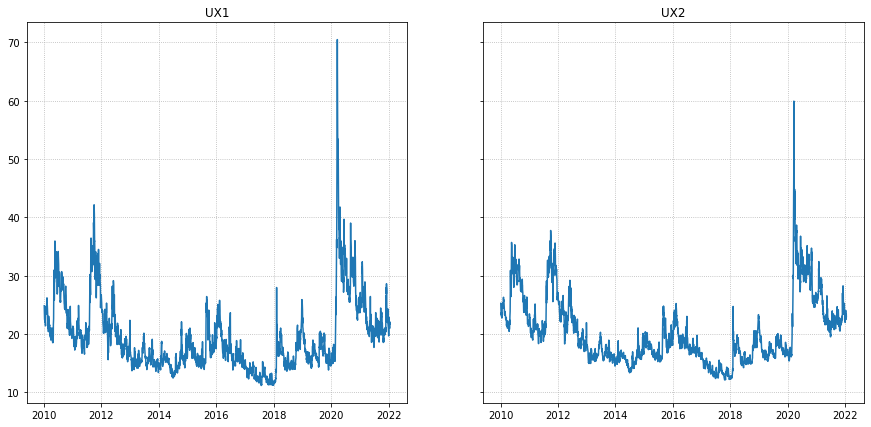

In [4]:
fig,ax = plt.subplots(ncols=2, figsize=(15,7), sharey=True)
ax[0].plot(UX1.index, UX1.PX_LAST)
ax[1].plot(UX2.index, UX2.PX_LAST)
ax[0].set_title('UX1')
ax[1].set_title('UX2')
ax[0].grid(linestyle='dotted')
ax[1].grid(linestyle='dotted')
plt.show()

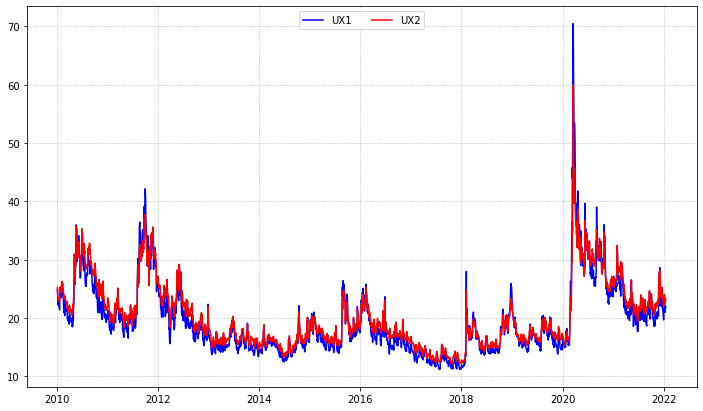

In [5]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot(UX1.index, UX1.PX_LAST, label='UX1', color='blue')
ax.plot(UX2.index, UX2.PX_LAST, label='UX2', color='red')
ax.legend(loc='upper center', ncol=2)
ax.grid(linestyle='dotted')
plt.show()

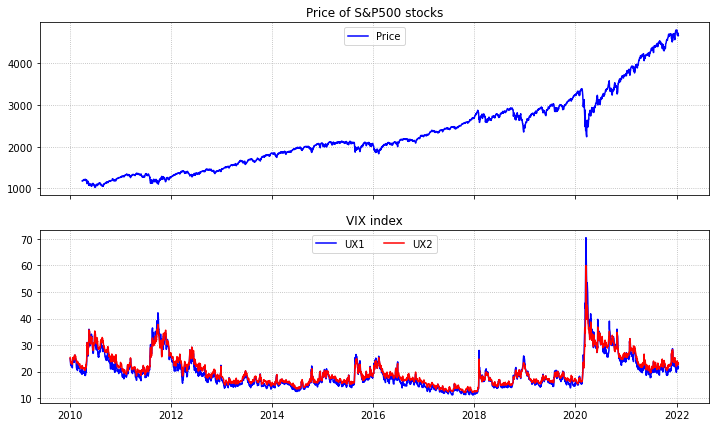

In [6]:
fig,ax = plt.subplots(nrows=2,figsize=(12,7), sharex=True)
ax[0].plot(SPX_price.index, SPX_price.Close, label='Price', color='blue')
ax[0].legend(loc='upper center', ncol=2)
ax[0].grid(linestyle='dotted')
ax[0].set_title('Price of S&P500 stocks')

ax[1].plot(UX1.index, UX1.PX_LAST, label='UX1', color='blue')
ax[1].plot(UX2.index, UX2.PX_LAST, label='UX2', color='red')
ax[1].legend(loc='upper center', ncol=2)
ax[1].grid(linestyle='dotted')
ax[1].set_title('VIX index')
plt.show()

## Heston Model

In [7]:
start     = '2010-04-05'
stop      = '2022-01-14'
mask      = ( UX1.index       >= start ) & ( UX1.index       < stop )
UX1       =   UX1[      mask]
mask      = ( UX2.index       >= start ) & ( UX2.index       < stop )
UX2       =   UX2[      mask]
mask      = ( SPX_price.index >= start ) & ( SPX_price.index < stop )
SPX_price =   SPX_price[mask]

UX1       = UX1.drop(UX1.drop(SPX_price.index).index)
UX1       = UX2.drop(UX2.drop(SPX_price.index).index)

In [8]:
def heston_pde_euler( S_0,   T,     r,     k,  theta,
                      v_0, rho, sigma, steps, Npaths ):
    dt         = T / steps
    size       = ( Npaths, steps )
    prices     = np.zeros(         size )
    volatility = np.zeros(         size )
    S_t        = np.full ( Npaths,  S_0 )
    v_t        = np.full ( Npaths,  v_0 )
    for t in range( steps ):
        WT  = np.sqrt( dt ) * np.random.multivariate_normal( np.array( [0,  0] ), np.array( [[1, rho], [rho, 1]] ), size=Npaths )

        S_t = S_t +              r * S_t                   * dt + S_t   * np.sqrt( v_t ) * WT[:, 0]
        #S_t = S_t * np.exp( (    r - 0.5           * v_t ) * dt +         np.sqrt( v_t ) * WT[:, 0] )
        v_t =       np.abs(    v_t +   k * ( theta - v_t ) * dt + sigma * np.sqrt( v_t ) * WT[:, 1] )

        prices[    :,t] = S_t
        volatility[:,t] = v_t

    return prices, volatility

In [9]:
def heston_pde_milstein( S_0,   T,     r,     k,  theta,
                         v_0, rho, sigma, steps, Npaths ):
    dt         = T / steps
    size       = ( Npaths, steps )
    prices     = np.zeros(         size )
    volatility = np.zeros(         size )
    S_t        = np.full ( Npaths,  S_0 )
    v_t        = np.full ( Npaths,  v_0 )
    for t in range( steps ):
        WT  = np.sqrt( dt ) * np.random.multivariate_normal( np.array( [0,  0] ), np.array( [[1, rho], [rho, 1]] ), size=Npaths )

        #S_t = S_t +              r * S_t                   * dt + S_t   * np.sqrt( v_t ) * WT[:, 0] + .25 *   S_t**2 * ( WT[:,0]**2 - dt )
        #S_t = S_t * np.exp( (    r - 0.5           * v_t ) * dt +         np.sqrt( v_t ) * WT[:, 0] )
        S_t =       np.log( S_t ) + ( r - 0.5  * v_t ) * dt + np.sqrt( v_t ) * WT[:, 0]
        v_t =       np.abs(    v_t +   k * ( theta - v_t ) * dt + sigma * np.sqrt( v_t ) * WT[:, 1] + .25 * sigma**2 * ( WT[:,1]**2 - dt ) )

        prices[    :, t] = S_t
        volatility[:, t] = v_t

    return prices, volatility

In [10]:
def r_comp(S, v, dt, N, rho):
    r  = np.empty( ( N, S.size ) )
    WT = np.random.normal( 0, 1, N )

    for t in range( 0, S.size-1 ):
        r[:, t]  = v[t] / 2 + np.log( S[t+1] / S[t] ) / dt - np.sqrt( v[t] / dt ) * WT[0]
        #r[:, t]  = v[t] / 2 + np.log( S[t+1] / S[t] ) / dt
        #r[:, t]  = ( S[t+1] / S[t] - 1 ) / dt #- np.sqrt( v[t] / dt ) * WT[:]
        #r[:, t]  = ( S[t+1] / S[t] - 1 ) / dt - np.sqrt( v[t] / dt ) * WT[0] - S[t] * ( WT[0]**2 - 1 ) / 4
        #r[:, t]  = ( S[t+1] / S[t] - 1 ) / dt
        #r[:, t]  = ( S[t+1] / S[t] - 1 ) / dt - np.sqrt( v[t] / dt ) * 0 - S[t] * ( 1 - 1 ) / 4
        #print( ( S[t+1] / S[t] - 1 ) / dt - np.sqrt( v[t] / dt )* WT[:, 0].mean() - S[t] * ( (WT[:, 0]**2).mean() - 1 ) / 4 )
    r[:, t+1] = r[:, t]
    return r.mean( axis=0 )

In [11]:
T       = 1 / 365
steps   = 1
Npaths  = 100
delta   = T / steps

rho     = -.7890 # don't know how to find it
#rt      = 100000   # don't know how to find it
r       = r_comp(SPX_price.Close.values, UX1.PX_LAST.values**2, delta, 1000, rho)
n       = 20

prices1 = np.empty( ( SPX_price.index.size - n, Npaths ) )
prices2 = np.empty( ( SPX_price.index.size - n, Npaths ) )
vol1    = np.empty( (       UX1.index.size - n, Npaths ) )
vol2    = np.empty( (       UX2.index.size - n, Npaths ) )

for i in range(n,UX1.index.size):
    Vt1             = UX1.PX_LAST.iloc[    i-n:i].values**2
    Vt2             = UX2.PX_LAST.iloc[    i-n:i].values**2
    S               = SPX_price.Close.iloc[i-n:i].values
    rt              = r[i-1]

    S0              = S[  -1]
    V10             = Vt1[-1]
    V20             = Vt2[-1]

    P1              = ( ( 1 / n    * sum( ( Vt1[i] * Vt1[i-1])**.5 for i in range( 1, n ) )   -
                          1 / n**2 * sum( ( Vt1[i] / Vt1[i-1])**.5 for i in range( 1, n ) )   *
                                     sum(            Vt1[i-1]      for i in range( 1, n ) ) ) /
                      ( delta / 2 - delta / ( 2 * n**2 )                                      *
                                     sum(            Vt1[i-1]      for i in range( 1, n ) ) ) )
    P2              = ( ( 1 / n    * sum( ( Vt2[i] * Vt2[i-1])**.5 for i in range( 1, n ) )   -
                          1 / n**2 * sum( ( Vt2[i] / Vt2[i-1])**.5 for i in range( 1, n ) )   *
                                     sum(            Vt2[i-1]      for i in range( 1, n ) ) ) /
                      ( delta / 2 - delta / ( 2 * n**2 )                                      *
                                     sum(            Vt2[i-1]      for i in range( 1, n ) ) ) )

    k1              = 2 / delta * (1 + P1 * delta / ( 2 * n ) * sum(        1 / Vt1[i-1]        for i in range( 1, n ) ) -
                                   1 / n  *                     sum( ( Vt1[i] / Vt1[i-1] )**0.5 for i in range( 1, n ) ) )
    k2              = 2 / delta * (1 + P2 * delta / ( 2 * n ) * sum(        1 / Vt2[i-1]        for i in range( 1, n ) ) -
                                   1 / n  *                     sum( ( Vt2[i] / Vt2[i-1] )**0.5 for i in range( 1, n ) ) )

    sigma1          = ( 4 / ( delta * n ) * sum( Vt1[i]**.5 - Vt1[i-1]**.5 - delta /
                      ( 2 * Vt1[i-1]**.5 ) *( P1 - k1 * Vt1[i-1] ) for i in range( 1, n ) ) )**.5
    sigma2          = ( 4 / ( delta * n ) * sum( Vt2[i]**.5 - Vt2[i-1]**.5 - delta /
                      ( 2 * Vt2[i-1]**.5 ) *( P2 - k2 * Vt2[i-1] ) for i in range( 1, n ) ) )**.5

    theta1          = ( P1 + sigma1**2 / 2 ) / k1
    theta2          = ( P2 + sigma2**2 / 2 ) / k2

    #p1, v1          = heston_pde_euler( S0, T, rt, k1, theta1, V10, rho, sigma1, steps, Npaths )
    #p2, v2          = heston_pde_euler( S0, T, rt, k2, theta2, V20, rho, sigma2, steps, Npaths )
    p1, v1          = heston_pde_milstein( S0, T, rt, k1, theta1, V10, rho, sigma1, steps, Npaths )
    p2, v2          = heston_pde_milstein( S0, T, rt, k2, theta2, V20, rho, sigma2, steps, Npaths )


    vol1[   i-n,:] = v1[:].ravel( )
    vol2[   i-n,:] = v2[:].ravel( )
    prices1[i-n,:] = p1[:].ravel( )
    prices2[i-n,:] = p2[:].ravel( )

In [12]:
vol1    = np.insert( vol1,    0, np.full( ( n, Npaths ), np.nan ), axis=0 )
vol2    = np.insert( vol2,    0, np.full( ( n, Npaths ), np.nan ), axis=0 )
prices1 = np.insert( prices1, 0, np.full( ( n, Npaths ), np.nan ), axis=0 )
prices2 = np.insert( prices2, 0, np.full( ( n, Npaths ), np.nan ), axis=0 )

for k in range(Npaths):
    col_vol  = 'sim_'   + str( k )
    col_pr1  = 'sim_1_' + str( k )
    col_pr2  = 'sim_2_' + str( k )
    UX1[      col_vol] = pd.Series( np.sqrt(   vol1[:,k] ), index =       UX1.index )
    UX2[      col_vol] = pd.Series( np.sqrt(   vol2[:,k] ), index =       UX2.index )
    SPX_price[col_pr1] = pd.Series( prices1[:,k], index = SPX_price.index )
    SPX_price[col_pr2] = pd.Series( prices2[:,k], index = SPX_price.index )


UX1[      'mean_sim' ] = ( UX1.loc[      :, ['sim_'   + str( k ) for k in range( Npaths ) ] ] ).mean( axis=1 )
UX2[      'mean_sim' ] = ( UX2.loc[      :, ['sim_'   + str( k ) for k in range( Npaths ) ] ] ).mean( axis=1 )
SPX_price['mean_sim1'] = ( SPX_price.loc[:, ['sim_1_' + str( k ) for k in range( Npaths ) ] ] ).mean( axis=1 )
SPX_price['mean_sim2'] = ( SPX_price.loc[:, ['sim_2_' + str( k ) for k in range( Npaths ) ] ] ).mean( axis=1 )

<ipython-input-12-64a3e7969f97>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPX_price[col_pr1] = pd.Series( prices1[:,k], index = SPX_price.index )
<ipython-input-12-64a3e7969f97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPX_price[col_pr2] = pd.Series( prices2[:,k], index = SPX_price.index )
<ipython-input-12-64a3e7969f97>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

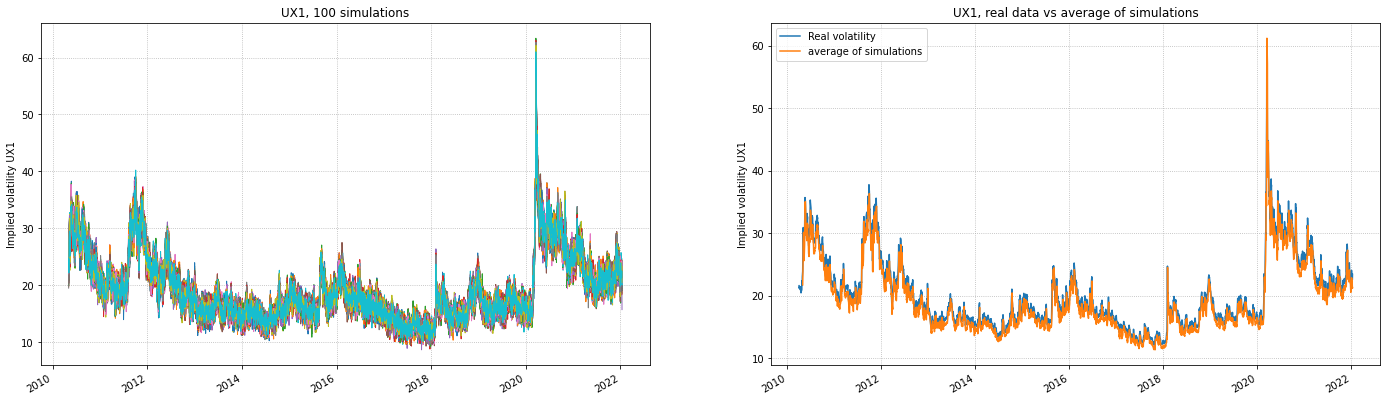

In [13]:
fig, ax = plt.subplots( ncols=2, figsize=( 24, 7 ) )

#ax[0].plot(UX1.index, UX1.PX_LAST, lw=2, label='Real volatility')
for k in range( Npaths ):
    col = 'sim_' + str(k)
    ax[0].plot( UX1.index, UX1[col], label='', lw=1 )
ax[0].grid( linestyle='dotted' )
#ax[0].legend(loc='upper left')
ax[0].set_title ( 'UX1, ' + str( Npaths ) + ' simulations' )
ax[0].set_ylabel( 'Implied volatility UX1' )

ax[1].plot( UX1.index, UX1.PX_LAST, label='Real volatility')
ax[1].plot( UX1.index, UX1['mean_sim'], label='average of simulations' )
ax[1].grid( linestyle='dotted')
ax[1].legend( loc='upper left')
ax[1].set_title ( 'UX1, real data vs average of simulations')
ax[1].set_ylabel( 'Implied volatility UX1')

fig.autofmt_xdate( )
plt.show()

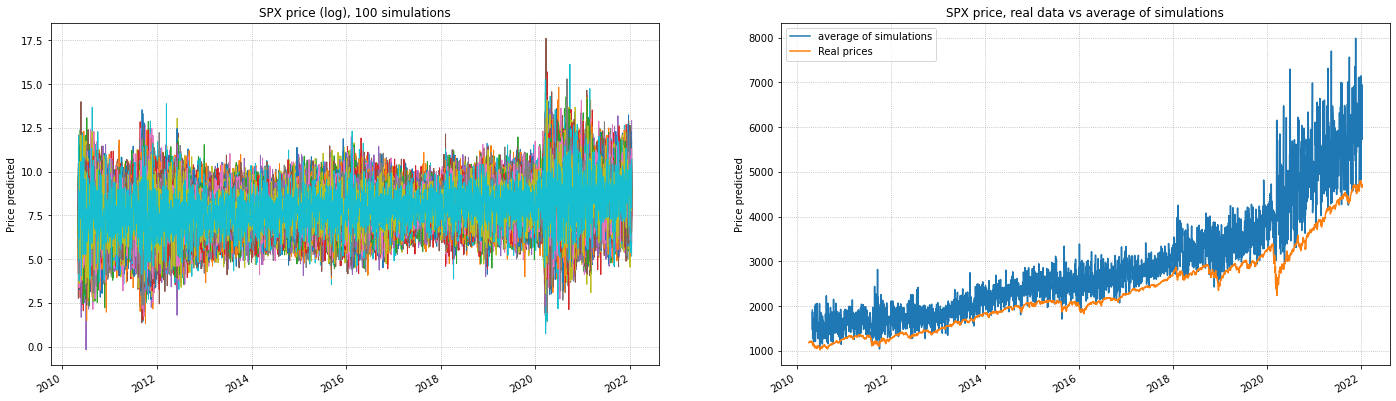

In [14]:
fig, ax = plt.subplots( ncols=2, figsize=( 24, 7 ) )

#ax[0].plot(UX1.index, UX1.PX_LAST, lw=2, label='Real volatility')
for k in range( Npaths ):
    col = 'sim_1_' + str(k)
    ax[0].plot( SPX_price.index, SPX_price[col], label='', lw=1 )
ax[0].grid( linestyle='dotted' )
#ax[0].legend(loc='upper left')
ax[0].set_title ( 'SPX price (log), ' + str( Npaths ) + ' simulations' )
ax[0].set_ylabel( 'Price predicted' )

ax[1].plot( SPX_price.index, np.exp(SPX_price['mean_sim1']), label='average of simulations' )
ax[1].plot( SPX_price.index, SPX_price.Close, label='Real prices')
ax[1].grid( linestyle='dotted')
ax[1].legend( loc='upper left')
ax[1].set_title ( 'SPX price, real data vs average of simulations')
ax[1].set_ylabel( 'Price predicted')

fig.autofmt_xdate( )
plt.show()

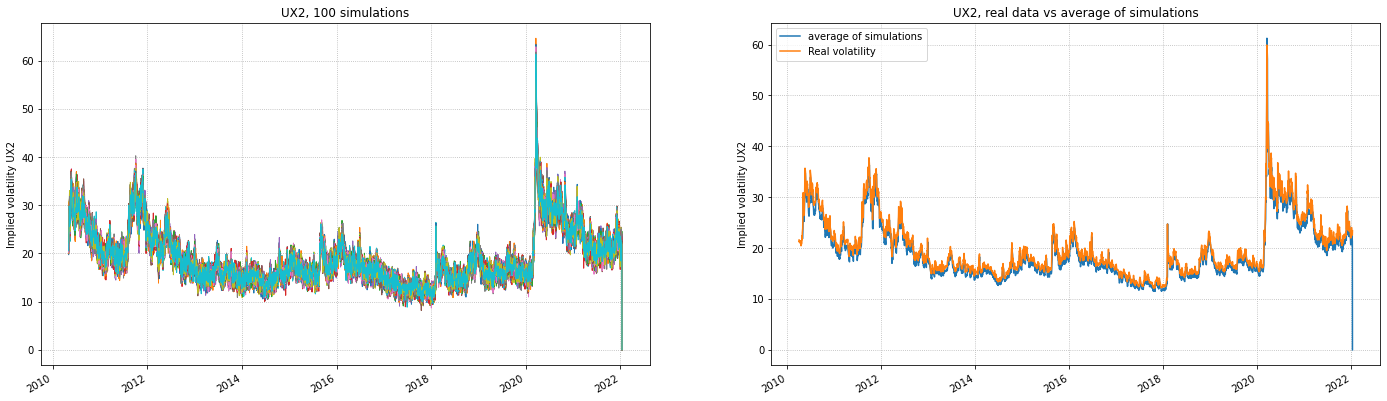

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(24,7))

for k in range(Npaths):
    col = 'sim_' + str(k)
    ax[0].plot(UX2.index, UX2[col], label='', lw=1)
#ax[0].plot(UX2.index, UX2.PX_LAST, lw=5, label='Real volatility')
ax[0].grid(linestyle='dotted')
#ax[0].legend(loc='best')
ax[0].set_title('UX2, ' + str(Npaths) + ' simulations')
ax[0].set_ylabel('Implied volatility UX2')

ax[1].plot(UX2.index, UX2['mean_sim'], label='average of simulations')
ax[1].plot(UX2.index, UX2.PX_LAST, label='Real volatility')
ax[1].grid(linestyle='dotted')
ax[1].legend(loc='best')
ax[1].set_title('UX2, real data vs average of simulations')
ax[1].set_ylabel('Implied volatility UX2')

fig.autofmt_xdate()
plt.show()

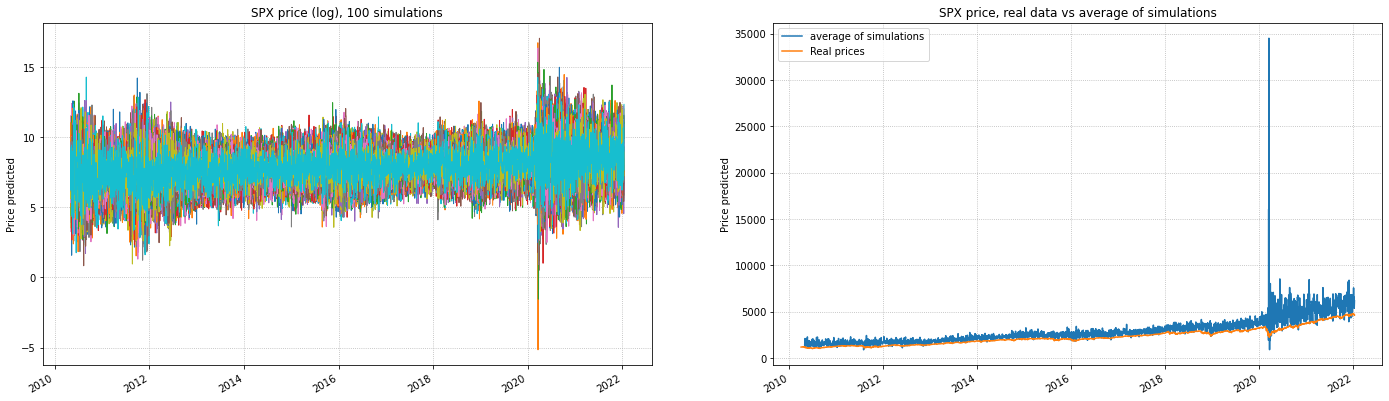

In [16]:
fig, ax = plt.subplots( ncols=2, figsize=( 24, 7 ) )

#ax[0].plot(UX1.index, UX1.PX_LAST, lw=2, label='Real volatility')
for k in range( Npaths ):
    col = 'sim_2_' + str(k)
    ax[0].plot( SPX_price.index, SPX_price[col], label='', lw=1 )
ax[0].grid( linestyle='dotted' )
#ax[0].legend(loc='upper left')
ax[0].set_title ( 'SPX price (log), ' + str( Npaths ) + ' simulations' )
ax[0].set_ylabel( 'Price predicted' )

ax[1].plot( SPX_price.index, np.exp(SPX_price['mean_sim2']), label='average of simulations' )
ax[1].plot( SPX_price.index, SPX_price.Close, label='Real prices')
ax[1].grid( linestyle='dotted')
ax[1].legend( loc='upper left')
ax[1].set_title ( 'SPX price, real data vs average of simulations')
ax[1].set_ylabel( 'Price predicted')

fig.autofmt_xdate( )
plt.show()

In [17]:
UX1[      'resid' ] =               UX1['mean_sim']    - UX1[      'PX_LAST']
UX2[      'resid' ] =               UX2['mean_sim']    - UX2[      'PX_LAST']
SPX_price['resid1'] = np.exp( SPX_price['mean_sim1'] ) - SPX_price['Close']
SPX_price['resid2'] = np.exp( SPX_price['mean_sim2'] ) - SPX_price['Close']

<ipython-input-17-7c5c6c8bf456>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPX_price['resid1'] = np.exp( SPX_price['mean_sim1'] ) - SPX_price['Close']
<ipython-input-17-7c5c6c8bf456>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPX_price['resid2'] = np.exp( SPX_price['mean_sim2'] ) - SPX_price['Close']


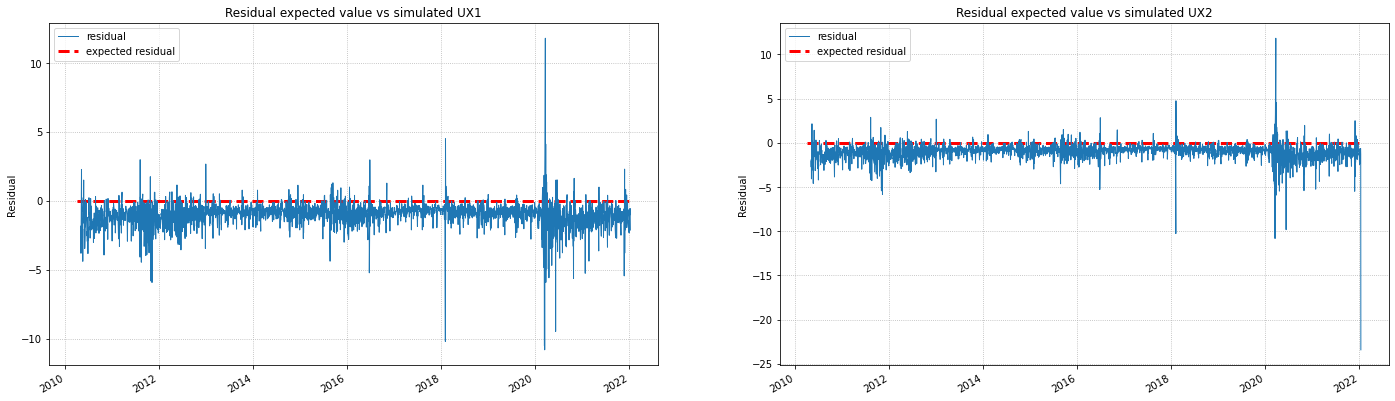

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(24,7))

ax[0].plot(UX1.index, UX1.resid, lw=1, label='residual')
ax[0].hlines(0, UX1.index.min(), UX1.index.max(), lw=3, color='red', linestyle='dashed', label='expected residual')
ax[0].grid(linestyle='dotted')
ax[0].legend(loc='best')
ax[0].set_title('Residual expected value vs simulated UX1')
ax[0].set_ylabel('Residual')

ax[1].plot(UX2.index, UX2.resid, lw=1, label='residual')
ax[1].hlines(0, UX2.index.min(), UX2.index.max(), lw=3, color='red', linestyle='dashed', label='expected residual')
ax[1].grid(linestyle='dotted')
ax[1].legend(loc='best')
ax[1].set_title('Residual expected value vs simulated UX2')
ax[1].set_ylabel('Residual')

fig.autofmt_xdate()
plt.show()

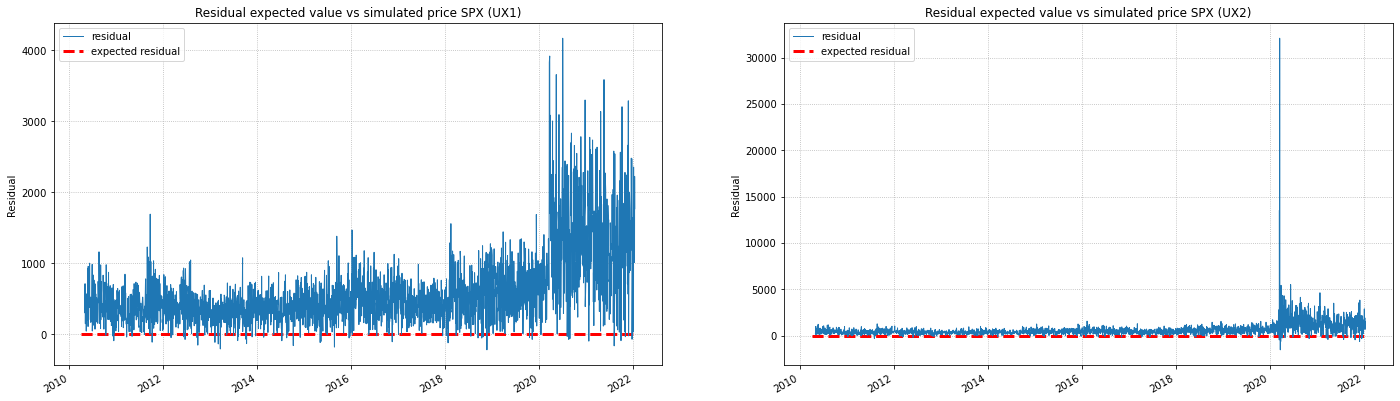

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(24,7))

ax[0].plot(SPX_price.index, SPX_price.resid1, lw=1, label='residual')
ax[0].hlines(0, SPX_price.index.min(), SPX_price.index.max(), lw=3, color='red', linestyle='dashed', label='expected residual')
ax[0].grid(linestyle='dotted')
ax[0].legend(loc='best')
ax[0].set_title('Residual expected value vs simulated price SPX (UX1)')
ax[0].set_ylabel('Residual')

ax[1].plot(SPX_price.index, SPX_price.resid2, lw=1, label='residual')
ax[1].hlines(0, SPX_price.index.min(), SPX_price.index.max(), lw=3, color='red', linestyle='dashed', label='expected residual')
ax[1].grid(linestyle='dotted')
ax[1].legend(loc='best')
ax[1].set_title('Residual expected value vs simulated price SPX (UX2)')
ax[1].set_ylabel('Residual')

fig.autofmt_xdate()
plt.show()

N  			=		 228.2772673115531 		+/-		 3.488380133105979
mu 			=		 -0.8260476287550299 		+/-		 0.008057797196923617
std			=		 0.4566443820775269 		+/-		 0.008057797213147085


R2 			=		 0.9634620834510141 
R 			=		 0.9815610441796344

Covariance matrix:
 [[ 1.         -0.07146139]
 [-0.07146139  1.        ]]

n degrees of freedom 	=		 84

chi2 			=		 396.6553260547749
p-value 		=		 0.0


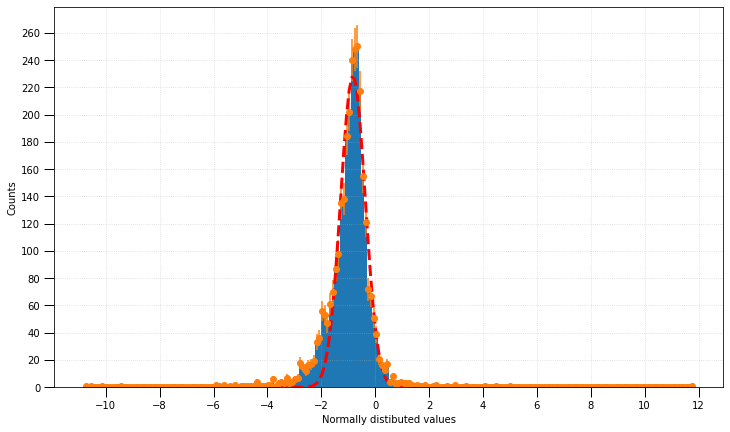

In [20]:
b                 = np.histogram_bin_edges(UX1.resid.dropna(), bins='fd')
fig, ax           = plt.subplots(figsize=(12, 7))
entries, edges, _ = ax.hist(UX1.resid, bins=b)
ax.set_ylabel('Counts')
ax.set_xlabel("Normally distibuted values")
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_major_locator(MultipleLocator( 2))
ax.tick_params(which='major', width=1.0)
ax.tick_params(which='major', length=10)
ax.grid(linestyle='dotted', alpha=0.5)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error. You can use what you want there
# poissonian 1 sigma intervals would make more sense
ax.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='o')

def gaussian(x, N, mu, sig):
    return N * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

popt, pcov = optimize.curve_fit(gaussian, bin_centers, entries, p0 = [100,0, 1])
ax.plot(bin_centers, gaussian(bin_centers, popt[0],popt[1],popt[2]), linestyle='dashed',c = 'r', lw=3 )

ssr = np.sum((entries - gaussian(bin_centers, popt[0],popt[1],popt[2]))**2)
tss = np.sum((np.mean(entries) - entries)**2)

rsq = 1 - ssr / tss
sigma_y  = np.sqrt(np.abs(entries))
mask_err = (sigma_y!=0)

print("N  \t\t\t=\t\t", popt[0], "\t\t+/-\t\t", pcov[0,0]**.5)
print("mu \t\t\t=\t\t", popt[1], "\t\t+/-\t\t", pcov[1,1]**.5)
print("std\t\t\t=\t\t", popt[2], "\t\t+/-\t\t", pcov[2,2]**.5)

print("\n")
print("R2 \t\t\t=\t\t", rsq, "\nR \t\t\t=\t\t", np.sqrt(rsq))
print("\nCovariance matrix:\n", np.corrcoef(bin_centers,entries)) # check with the correlation matrix that R is the correlation coefficient

ndof = len(bin_centers[mask_err]) - 3
print("\nn degrees of freedom \t=\t\t", ndof)
# calculate the chi^2
chi2 = np.sum(((entries[mask_err] - (gaussian(bin_centers[mask_err], popt[0],popt[1],popt[2])))**2) / sigma_y[mask_err]**2)
print("\nchi2 \t\t\t=\t\t", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value \t\t=\t\t", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

N  			=		 229.96449626826555 		+/-		 2.9121924185859367
mu 			=		 -0.8280721222316338 		+/-		 0.006657963789254051
std			=		 0.4553058943135447 		+/-		 0.00665796380558606


R2 			=		 0.9623613582729595 
R 			=		 0.9810001826059767

Covariance matrix:
 [[1.         0.11652218]
 [0.11652218 1.        ]]

n degrees of freedom 	=		 80

chi2 			=		 405.3271382877648
p-value 		=		 0.0


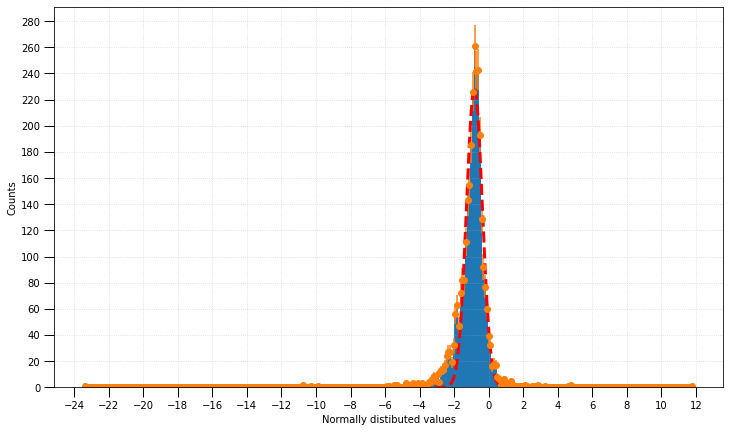

In [21]:
b                 = np.histogram_bin_edges(UX2.resid.dropna(), bins='fd')
fig, ax           = plt.subplots(figsize=(12, 7))
entries, edges, _ = ax.hist(UX2.resid, bins=b)
ax.set_ylabel('Counts')
ax.set_xlabel("Normally distibuted values")
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_major_locator(MultipleLocator( 2))
ax.tick_params(which='major', width=1.0)
ax.tick_params(which='major', length=10)
ax.grid(linestyle='dotted', alpha=0.5)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error. You can use what you want there
# poissonian 1 sigma intervals would make more sense
ax.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='o')

def gaussian(x, N, mu, sig):
    return N * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

popt, pcov = optimize.curve_fit(gaussian, bin_centers, entries, p0 = [100,0, 1])
ax.plot(bin_centers, gaussian(bin_centers, popt[0],popt[1],popt[2]), linestyle='dashed',c = 'r', lw=3 )

ssr = np.sum((entries - gaussian(bin_centers, popt[0],popt[1],popt[2]))**2)
tss = np.sum((np.mean(entries) - entries)**2)

rsq = 1 - ssr / tss
sigma_y  = np.sqrt(np.abs(entries))
mask_err = (sigma_y!=0)

print("N  \t\t\t=\t\t", popt[0], "\t\t+/-\t\t", pcov[0,0]**.5)
print("mu \t\t\t=\t\t", popt[1], "\t\t+/-\t\t", pcov[1,1]**.5)
print("std\t\t\t=\t\t", popt[2], "\t\t+/-\t\t", pcov[2,2]**.5)

print("\n")
print("R2 \t\t\t=\t\t", rsq, "\nR \t\t\t=\t\t", np.sqrt(rsq))
print("\nCovariance matrix:\n", np.corrcoef(bin_centers,entries)) # check with the correlation matrix that R is the correlation coefficient

ndof = len(bin_centers[mask_err]) - 3
print("\nn degrees of freedom \t=\t\t", ndof)
# calculate the chi^2
chi2 = np.sum(((entries[mask_err] - (gaussian(bin_centers[mask_err], popt[0],popt[1],popt[2])))**2) / sigma_y[mask_err]**2)
print("\nchi2 \t\t\t=\t\t", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value \t\t=\t\t", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

N  			=		 244.30757071675805 		+/-		 5.440752851313474
mu 			=		 411.50151735313545 		+/-		 6.509962500308894
std			=		 253.35910812390057 		+/-		 6.55991453305744


R2 			=		 0.9693744417961547 
R 			=		 0.9845681498993123

Covariance matrix:
 [[ 1.         -0.64002301]
 [-0.64002301  1.        ]]

n degrees of freedom 	=		 59

chi2 			=		 451.15168579226076
p-value 		=		 0.0


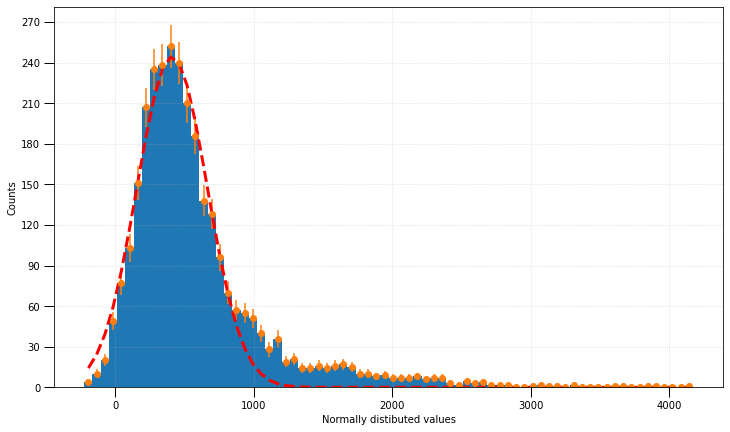

In [22]:
b                 = np.histogram_bin_edges(SPX_price.resid1.dropna(), bins='fd')
fig, ax           = plt.subplots(figsize=(12, 7))
entries, edges, _ = ax.hist(SPX_price.resid1, bins=b)
ax.set_ylabel('Counts')
ax.set_xlabel("Normally distibuted values")
ax.yaxis.set_major_locator(MultipleLocator(30))
#ax.xaxis.set_major_locator(MultipleLocator(50))
ax.tick_params(which='major', width=1.0)
ax.tick_params(which='major', length=10)
ax.grid(linestyle='dotted', alpha=0.5)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error. You can use what you want there
# poissonian 1 sigma intervals would make more sense
ax.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='o')

def gaussian(x, N, mu, sig):
    return N * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

popt, pcov = optimize.curve_fit(gaussian, bin_centers, entries, p0 = [300,0, 500])
ax.plot(bin_centers, gaussian(bin_centers, popt[0],popt[1],popt[2]), linestyle='dashed',c = 'r', lw=3 )

ssr = np.sum((entries - gaussian(bin_centers, popt[0],popt[1],popt[2]))**2)
tss = np.sum((np.mean(entries) - entries)**2)

rsq = 1 - ssr / tss
sigma_y  = np.sqrt(np.abs(entries))
mask_err = (sigma_y!=0)

print("N  \t\t\t=\t\t", popt[0], "\t\t+/-\t\t", pcov[0,0]**.5)
print("mu \t\t\t=\t\t", popt[1], "\t\t+/-\t\t", pcov[1,1]**.5)
print("std\t\t\t=\t\t", popt[2], "\t\t+/-\t\t", pcov[2,2]**.5)

print("\n")
print("R2 \t\t\t=\t\t", rsq, "\nR \t\t\t=\t\t", np.sqrt(rsq))
print("\nCovariance matrix:\n", np.corrcoef(bin_centers,entries)) # check with the correlation matrix that R is the correlation coefficient

ndof = len(bin_centers[mask_err]) - 3
print("\nn degrees of freedom \t=\t\t", ndof)
# calculate the chi^2
chi2 = np.sum(((entries[mask_err] - (gaussian(bin_centers[mask_err], popt[0],popt[1],popt[2])))**2) / sigma_y[mask_err]**2)
print("\nchi2 \t\t\t=\t\t", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value \t\t=\t\t", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

N  			=		 247.88602776963126 		+/-		 2.058908080578508
mu 			=		 408.9941054712154 		+/-		 2.365211806379377
std			=		 246.6096577820615 		+/-		 2.3652118259976516


R2 			=		 0.9736855712563277 
R 			=		 0.9867550715635202

Covariance matrix:
 [[ 1.         -0.27711799]
 [-0.27711799  1.        ]]

n degrees of freedom 	=		 74

chi2 			=		 473.3508205337329
p-value 		=		 0.0


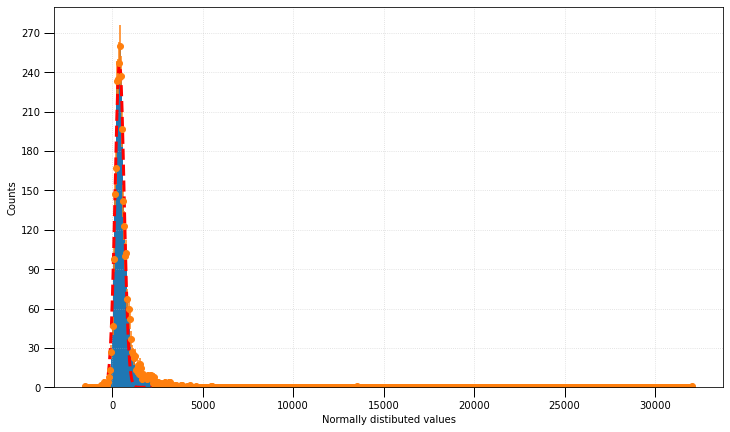

In [23]:
b                 = np.histogram_bin_edges(SPX_price.resid2.dropna(), bins='fd')
fig, ax           = plt.subplots(figsize=(12, 7))
entries, edges, _ = ax.hist(SPX_price.resid2, bins=b)
ax.set_ylabel('Counts')
ax.set_xlabel("Normally distibuted values")
ax.yaxis.set_major_locator(MultipleLocator(30))
#ax.xaxis.set_major_locator(MultipleLocator(50))
ax.tick_params(which='major', width=1.0)
ax.tick_params(which='major', length=10)
ax.grid(linestyle='dotted', alpha=0.5)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error. You can use what you want there
# poissonian 1 sigma intervals would make more sense
ax.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='o')

popt, pcov = optimize.curve_fit(gaussian, bin_centers, entries, p0 = [300,0, 500])
ax.plot(bin_centers, gaussian(bin_centers, popt[0],popt[1],popt[2]), linestyle='dashed',c = 'r', lw=3 )

ssr = np.sum((entries - gaussian(bin_centers, popt[0],popt[1],popt[2]))**2)
tss = np.sum((np.mean(entries) - entries)**2)

rsq = 1 - ssr / tss
sigma_y  = np.sqrt(np.abs(entries))
mask_err = (sigma_y!=0)

print("N  \t\t\t=\t\t", popt[0], "\t\t+/-\t\t", pcov[0,0]**.5)
print("mu \t\t\t=\t\t", popt[1], "\t\t+/-\t\t", pcov[1,1]**.5)
print("std\t\t\t=\t\t", popt[2], "\t\t+/-\t\t", pcov[2,2]**.5)

print("\n")
print("R2 \t\t\t=\t\t", rsq, "\nR \t\t\t=\t\t", np.sqrt(rsq))
print("\nCovariance matrix:\n", np.corrcoef(bin_centers,entries)) # check with the correlation matrix that R is the correlation coefficient

ndof = len(bin_centers[mask_err]) - 3
print("\nn degrees of freedom \t=\t\t", ndof)
# calculate the chi^2
chi2 = np.sum(((entries[mask_err] - (gaussian(bin_centers[mask_err], popt[0],popt[1],popt[2])))**2) / sigma_y[mask_err]**2)
print("\nchi2 \t\t\t=\t\t", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value \t\t=\t\t", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

Sistematic underestimation of volatility

Problems on prices (i get values without any sense)

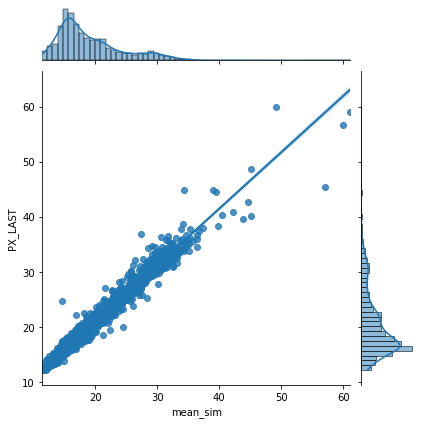

In [24]:
sns.jointplot(x='mean_sim', y='PX_LAST', data=UX1, kind='reg')

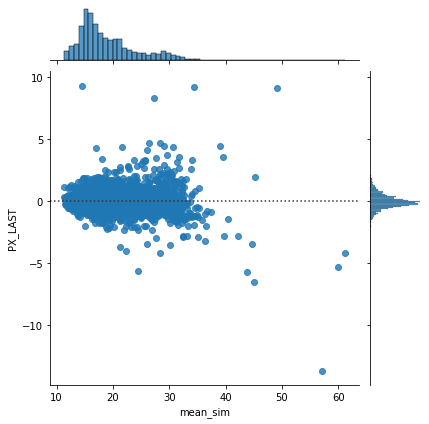

In [25]:
sns.jointplot(x='mean_sim', y='PX_LAST', data=UX1, kind='resid')

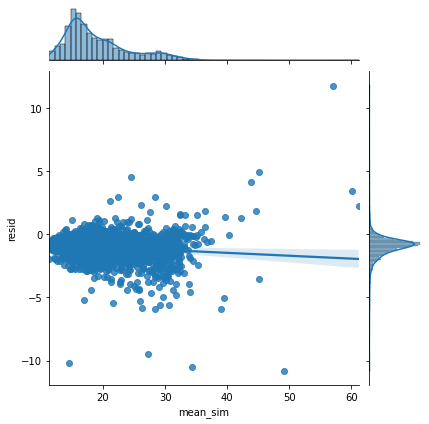

In [26]:
sns.jointplot(x='mean_sim', y='resid', data=UX1, kind='reg')

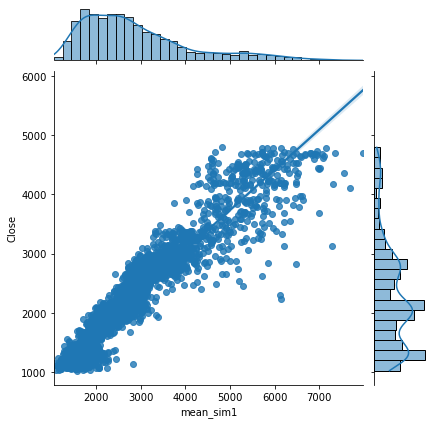

In [27]:
sns.jointplot(x=np.exp(SPX_price['mean_sim1']), y=SPX_price['Close'], kind='reg')

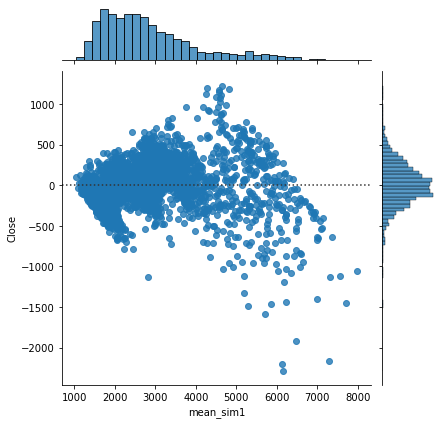

In [28]:
sns.jointplot(x=np.exp(SPX_price['mean_sim1']), y=SPX_price['Close'], kind='resid')

In [29]:
# characteristic function
def f( phi, kappa, theta, sigma,    rho,
        v0,     r,     T,    s0, status ):

    a = kappa * theta
    x = np.log( s0 )

    # remind that lamda is zero
    if status == 1:
        u = 0.5
        b = kappa - rho * sigma
    else:
        u = -.5
        b = kappa

    d = np.sqrt( (   rho * sigma * phi * 1j - b )**2 - sigma**2 * ( 2 * u * phi * 1j - phi**2 ) )
    g =        ( b - rho * sigma * phi * 1j + d)     / (b - rho   * sigma * phi * 1j -      d   )

    C = ( r * phi * 1j * T + ( a / sigma**2 ) * ( ( b - rho * sigma * phi * 1j + d ) *
          T - 2 * np.log( ( 1 - g * np.exp( d * T ) ) / ( 1 - g ) ) ) )
    D = ( b - rho * sigma * phi * 1j + d ) / ( sigma**2 ) * ( ( 1 - np.exp( d * T ) ) / ( 1 - g * np.exp( d * T ) ) )

    return np.exp( C + D * v0 + 1j * phi * x )

# P1 and P2
def p( kappa, theta, sigma, rho, v0, r, T, s0, K, status ):
    integrand = lambda phi: ( np.exp( -1j * phi * np.log( K ) ) *
                              f( phi, kappa, theta, sigma, rho, v0, r, T, s0, status ) / ( 1j * phi ) ).real

    return ( 0.5 + ( 1 / np.pi ) * integrate.quad( integrand, 0, 100 )[0] ) # approximate indefinite intergral with a definite one

def p1(       kappa, theta, sigma, rho, v0, r, T, s0, K    ):
    return p( kappa, theta, sigma, rho, v0, r, T, s0, K, 1 )

def p2(       kappa, theta, sigma, rho, v0, r, T, s0, K    ):
    return p( kappa, theta, sigma, rho, v0, r, T, s0, K, 2 )

# call price
def call_price( kappa, theta, sigma, rho, v0, r, T, s0, K ):
    P1 = p1( kappa, theta, sigma, rho, v0, r, T, s0, K )
    P2 = p2( kappa, theta, sigma, rho, v0, r, T, s0, K )
    print(P1, P2)
    result = ( s0 * P1 - K * np.exp( -r * T ) * P2 )

    if result < 0 or k - s0 > 1: # negative result or initial price very very low with respect to k
        result = 0

    return result

In [30]:
T       = 1
steps   = 1
Npaths  = 100
delta   = T / steps

rho     = -.7890 # don't know how to find it
#r       = 2.17   # don't know how to find it
r       = r_comp(SPX_price.Close.values, UX1.PX_LAST.values**2, delta, 1000, rho)
n       = 30

call_prices = np.empty( ( UX1.index.size - n, Npaths ) )

for i in range(n,UX1.index.size):
    Vt1             = UX1.PX_LAST.iloc[    i-n:i].values**2
    Vt2             = UX2.PX_LAST.iloc[    i-n:i].values**2
    S               = SPX_price.Close.iloc[i-n:i].values
    rt              = r[i]

    S0              = S[  -1]
    V10             = Vt1[-1]
    V20             = Vt2[-1]

    P_1             = ( ( 1 / n    * sum( ( Vt1[i] * Vt1[i-1])**.5 for i in range( 1, n ) )   -
                          1 / n**2 * sum( ( Vt1[i] / Vt1[i-1])**.5 for i in range( 1, n ) )   *
                                     sum(            Vt1[i-1]      for i in range( 1, n ) ) ) /
                      ( delta / 2 - delta / ( 2 * n**2 )                                      *
                                     sum(            Vt1[i-1]      for i in range( 1, n ) ) ) )
    P_2             = ( ( 1 / n    * sum( ( Vt2[i] * Vt2[i-1])**.5 for i in range( 1, n ) )   -
                          1 / n**2 * sum( ( Vt2[i] / Vt2[i-1])**.5 for i in range( 1, n ) )   *
                                     sum(            Vt2[i-1]      for i in range( 1, n ) ) ) /
                      ( delta / 2 - delta / ( 2 * n**2 )                                      *
                                     sum(            Vt2[i-1]      for i in range( 1, n ) ) ) )

    k1              = 2 / delta * (1 + P_1 * delta / ( 2 * n ) * sum(        1 / Vt1[i-1]        for i in range( 1, n ) ) -
                                   1 / n   *                     sum( ( Vt1[i] / Vt1[i-1] )**0.5 for i in range( 1, n ) ) )
    k2              = 2 / delta * (1 + P_2 * delta / ( 2 * n ) * sum(        1 / Vt2[i-1]        for i in range( 1, n ) ) -
                                   1 / n   *                     sum( ( Vt2[i] / Vt2[i-1] )**0.5 for i in range( 1, n ) ) )

    sigma1          = ( 4 / ( delta * n ) * sum( Vt1[i]**.5 - Vt1[i-1]**.5 - delta /
                      ( 2 * Vt1[i-1]**.5 ) *( P_1 - k1 * Vt1[i-1] ) for i in range( 1, n ) ) )**.5
    sigma2          = ( 4 / ( delta * n ) * sum( Vt2[i]**.5 - Vt2[i-1]**.5 - delta /
                      ( 2 * Vt2[i-1]**.5 ) *( P_2 - k2 * Vt2[i-1] ) for i in range( 1, n ) ) )**.5

    theta1          = ( P_1 + sigma1**2 / 2 ) / k1
    theta2          = ( P_2 + sigma2**2 / 2 ) / k2

    P_1              = call_price( k1, theta1, sigma1, rho, V10, rt, T, S0, 100 )
    #P_1, v1          = heston_pde_milstein( S0, T, rt, k1, theta1, V10, rho, sigma1, steps, Npaths )
    #P_2, v2          = heston_pde_milstein( S0, T, rt, k2, theta2, V20, rho, sigma2, steps, Npaths )


    call_prices[i-n,:] = P_1.ravel( )

1.0000000000023013 0.6883355093329022
0.9999999999945914 0.9187427519624531
0.9999999999994538 0.835556870523056
0.9999999999998652 0.997509772342925
0.9999999999358428 0.5382867641600644
0.9999999999222888 0.37286872388988024
1.000000000060433 0.27515956904314154
1.0000000000942455 0.3251878692781508
0.9999999999999676 0.06434981225396363
0.9999999999994903 0.6530733016850334
1.0000000000007272 0.6882994431206707
1.0000000000001172 0.23546055937542193
0.9999999999982027 0.4836453886137366
1.0000000000020917 0.9333722354673035
0.9999999999998928 0.776890175933145
0.9999999999999538 0.29279904249745126
0.9999999999996585 0.6806438065258904
1.0000000000001927 0.21440533180319188
0.9999999999997069 0.41974889438484614
0.9999999999966551 0.499321747121873
0.9999999999978455 0.22813311691172267
1.0000000000106284 0.5177705118458295
1.0000000000499394 0.4947072866930926
0.999999999929857 0.4408610588137003
1.0000000003452971 0.6513247660291848
0.9999999999641844 0.801441293971643
0.999999999

0.9999999999999969 0.40136640233002535
1.0000000000000004 0.5033645856738089
1.0000000000000044 0.606565826554768
1.0000000000000027 0.7392799914892934
1.0000000000000013 0.5064510171604002
0.9999999999999968 0.573854864984972
1.0000000000000022 0.5924676506540606
1.0000000000000009 0.6472736899912583
1.0000000000000027 0.6687127194700598
1.000000000000004 0.5666321840391589
1.0000000000000009 0.6338435127379289
0.999999999999998 0.5193385852710181
1.0 0.5740474365479307
1.0000000000000004 0.5182969941828625
1.0 0.7388816732119649
0.9999999999999984 0.40516855857331463
0.9999999999999996 0.3936322574391259
0.9999999999999968 0.4974000203398492
1.0000000000000022 0.48200759612119837
1.0000000000000022 0.4834914113781705
1.0 0.47240719343614856
0.9999999999999994 0.5073331378501609
0.999999999999999 0.5919022885675902
0.9999999999999991 0.9472413301492016
0.9999999999999982 0.7163324285247865
1.0000000000000004 0.6492015995963236
0.9999999999999967 0.6322312467649525
0.999999999999996 0.

0.9999999999999962 0.8119867177391349
0.9999999999999947 0.8332012935328588
0.9999999999999958 0.4348579245967117
0.9999999999999987 0.6885677990319578
0.9999999999999978 0.9307698388432031
1.0000000000375198 0.3368380146690574
0.999999999999992 0.6430802614379856
1.0000000013425399 0.6935663951147721
1.0000000004016782 0.4281338263751683
1.0000000008006142 0.2718095287743276
0.9999999999999953 0.8289183947114156
0.9999999999999989 0.6671462939414675
1.000000002131177 0.4580058035082184
1.000000000000004 0.5868591549147915
1.0000000000000004 0.8362466015971237
0.9999999984898484 0.7136495529333154
1.0000000006356848 0.6182212188075057
1.0000000008865189 0.8385118671769982
0.9999999999724964 0.3085795163498516
0.9999999994762687 0.41284363321135104
1.0000000008320806 0.4708160867658896
1.000000000554243 0.40022454219983106
0.9999999999999987 0.37598627299833143
1.0000000000000036 0.7903271403057663
0.9999999999999946 0.5504428731725981
0.9999999999999999 0.5763366821519106
0.99999999999

1.0000000000000016 0.9860447024048419
0.9999999999999989 0.011958733389839271
1.0000000000000036 0.46837183128917753
1.0000000000000009 0.5975417138425809
1.0 0.5503319679234825
0.9999999999999969 0.5522338761176309
0.9999999999999984 0.565242615826941
1.0000000000000009 0.592579333060364
0.9999999999999984 0.5203588161232376
0.9999999999999996 0.5484182458049602
1.0000000000000013 0.488101397537359
0.9999999999999992 0.549260761505556
0.9999999999999996 0.5432861850844257
1.0000000000000018 0.5589525353097505
1.000000000000003 0.3817237980092018
1.0000000000000044 0.3306761534906087
1.0000000000000537 0.4885717603905288
0.9999999999998667 0.606884787670069
1.000000000000024 0.604743424542631
0.999999999999994 0.649380619668303
1.0000000000000009 0.47402805250556
1.000000000000199 0.8120136155979754
1.0000000000000127 0.5724015518545023
1.000000000000004 0.7488852215095244
1.0000000000000024 0.6993750626595892
1.0000000000000013 0.5413258174480434
0.9999999999999958 0.5438215980805841


1.0000000000000009 0.5744633939338667
1.0000000000000009 0.5579013385896162
1.0000000000000018 0.5479134255904797
0.9999999999999982 0.6676525849706941
0.9999999999999979 0.4749466573661395
1.0000000000000018 0.44099233454563813
0.9999999999999984 0.5005396916296531
1.0000000000000329 0.5480959329466577
0.9999999999999816 0.5805327447563355
1.000000000000029 0.6201110479465024
1.0000000000000364 0.600794434452935
0.9999999999999563 0.8649792704517798
0.9999999999999958 0.6377175169491459
0.9999999999999964 0.5635458855654623
1.0000000000000002 0.5789594993896768
0.9999999999999994 0.4585830677308357
0.9999999999999991 0.5058196210188544
0.9999999999999949 0.611129082006583
0.9999999999999969 0.7216361227843592
0.9999999999999992 0.5936876155436637
0.9999999999999997 0.5932492234776863
0.9999999999999971 0.6147033605241125
1.0000000000000004 0.523731125148645
0.999999999999995 0.3366085706339918
0.9999999999999838 0.6025123540984324
0.9999999999999991 0.5445554021093694
0.99999999999999

1.000000000000001 0.7262406463517532
1.000000000000003 0.5230059106098033
1.0000000000000022 0.3078364349993349
0.9999999999999971 0.675573269861457
0.9999999999999987 0.7991277919396493
1.000000000000003 0.21300575319580795
0.9999999999999994 0.8425018365292527
1.0000000000000044 0.8895069405951219
1.0000000000000018 0.9133304386652845
1.0000000000000036 0.31332987638132603
1.0000000000000013 0.949013680285196
0.9999999999999977 0.2952177576451296
0.9999999999999982 0.31102915178015267
1.0000000000000018 0.2896871931148671
1.0000000000000004 0.24621188984946163
0.9999999999999962 0.7978456055241911
1.0000000000000004 0.34897310441013263
1.0000000000000004 0.4985163548575241
0.9999999999999991 0.5170878470348663
1.0000000000000004 0.30192515350566107
0.9999999999999979 0.6927080770047968
1.0000000000000022 0.5763569319901828
0.9999999999999984 0.5026956584124969
1.000000000000008 0.8243936762452504
0.9999999999999999 0.5935814003626204
0.9999999999999996 0.4864446698461693
1.0 0.462440

1.0000000000000022 0.8458147696837487
0.9999999999999936 0.8902506733663436
1.000000000000003 0.999478332495628
1.0000000000000004 0.5682240091691476
0.9999999999999942 0.2521301549317443
0.999999999999998 0.575454158379898
1.0000000000000027 0.6478406801408312
0.9999999999999993 0.9052044141218691
1.0000000006450263 0.8544014736931806
0.9999999998822517 0.1660929095567223
1.0000000000000053 0.5894473520252
1.0000000015059691 0.8850403441307813
0.9999999999129082 0.1498916611948366
1.0000000016758515 0.6616404996169869
0.9999999994538369 0.37012541636168395
1.0000000000000036 0.45859548070659883
0.999999999999998 0.5342608730112254
0.9999999999999997 0.0916460099017476
0.9999999999999968 0.1940826599035756
0.9999999999999987 0.7855642686551803
0.9999999999999991 0.7998573223729986
0.9999999999999989 0.2457884928107762
1.0000000000000013 0.873230562048628
1.0000000000000027 0.4294300564761191
0.9999999999999992 0.7016770238173118
0.9999999999999991 0.6985706310915292
0.9999999999999996 

0.9999999999999998 0.5531155835879994
0.9999999999999999 0.46397322815506764
1.0000000000000009 0.5535898841996654
1.000000000000001 0.55781618889055
1.0000000000000009 0.6438465609569078
0.9999999999999977 0.43888471647910476
0.9999999999999993 0.609105553702397
0.9999999999999987 0.550823605239911
1.0000000000000007 0.7381427745010762
1.0000000000000018 0.5137834823274928
0.9999999999999978 0.6069989035195855
1.0000000000000044 0.5714119330935334
1.0000000000000004 0.5411846668767564
1.0000000000000018 0.4964369723149913
1.0000000000000004 0.45218466602510426
1.0 0.9149940006917492
0.9999999999999976 0.703071707571283
1.0000000000000027 0.5083819154810477
0.9999999999999976 0.5111743359478698
1.0 0.4512715599377803
0.9999999999999993 0.5265552748971336
1.0000000000000022 0.5157319717677273
0.9999999999999998 0.6425560415905587
0.9999999999999961 0.5809090839867251
1.0000000000000004 0.5802511498861296
1.0000000000000013 0.5405117522292506
0.9999999999999984 0.7241571961755262
0.99999

0.9999999999987148 0.5717588771022344
1.0000000000011267 0.5391471433832824
1.0000000000017448 0.5859063868086414
1.0000000000054965 0.7781527857635765
1.000000000000841 0.6250098842193428
1.0000000000005698 0.5940940322137669
0.9999999999993121 0.6488836297600425
0.9999999999996338 0.5569521243105329
1.0000000000004468 0.5276063342077855
1.0000000000001332 0.5895453883721904
1.0000000000008662 0.6194541418603438
0.9999999999994522 0.5000266429153883
1.0000000000013025 0.5639899144291874
1.0000000000018436 0.625324870783279
1.0000000000009952 0.548211158888581
0.9999999999997855 0.5190943442626755
1.0000000000031704 0.5971065539340021
1.0000000000023608 0.6266028988532257
1.0000000000019744 0.5659866035502846
1.0000000000008187 0.5667214663870593
1.0000000000000786 0.5214994152258471
0.9999999999925371 0.6853042736292758
0.9999999999972226 0.534058100171871
0.9999999999945262 0.6475664994990733
1.0000000000004707 0.6166351911739484
1.000000000006117 0.892451910190375
0.9999999999998996

0.9999999999999959 0.47322953457981565
1.0000000000000036 0.38727303594253015
0.999999999999998 0.3884093858915051
1.0000000000000056 0.5377733620337058
0.9999999999999984 0.6391797707675194
1.000000000000004 0.6650849989183772
1.000000000000003 0.5744159355978232
0.9999999999999993 0.7150755603804968
0.9999999999999962 0.6470990038940251
1.0000000000000004 0.40066754670191335
0.9999999999999998 0.5328227366004076
0.9999999999999991 0.6198714789036144
1.0000000000000004 0.5789174648186697
1.0 0.6644832807307426
1.0000000000000002 0.5335196519831983
1.0000000000000009 0.5541429752544265
1.0000000000000022 0.6026099028449
1.0 0.5708046220736606
1.0000000000000027 0.4572507167197889
1.0000000000000007 0.4460148869046039
0.9999999999999938 0.49729047984714575
0.9999999999999747 0.5288956456979186
1.0000000000002187 0.8130104265084661
1.0000000000000053 0.47239109446182026
1.0000000000000457 0.5322743666039783
1.0000000000000013 0.6801939482776034
0.9999999999999685 0.4465484663067287
1.000

1.0000000000000038 0.716930088764621
1.0000000000000004 0.6886098237150793
1.0000000000000007 0.6306027599189761
1.000000000000003 0.350570922763658
0.9999999999999968 0.5455437891592956
0.9999999999999991 0.5452308961087939
0.9999999999999953 0.5738697215391538
1.0000000000000056 0.512282160890735
1.0000000000000044 0.6451577540063942
0.9999999999999896 0.6568651898263022
1.0000000000000049 0.6553115113263474
1.0000000000000036 0.5366870465556652
1.0000000000000027 0.8803486992040952
0.9999999999999962 0.6212909923623594
1.0000000000000013 0.4276939538309349
1.0000000000000036 0.6783156079093461
1.0000000000000022 0.48694143733864526
1.0000000000000036 0.5052184202430173
0.999999999999999 0.5934347273472586
0.9999999999999984 0.6371166032991864
0.9999999999999996 0.5465466441368504
0.9999999999999999 0.5930620841016505
0.9999999999999997 0.5161003537470192
1.0000000000000004 0.5779081039036187
1.0000000000000022 0.7323198690646466
1.0 0.4871393808989555
1.0 0.5483623856326284
1.000000

1.0000000000000067 0.5913468653834598
1.0000000000000135 0.7541863623312346
0.9999999999999993 0.8655972472223716
0.9999999999999953 0.44467979881890657
0.9999999999999987 0.5788823063612636
0.9999999999999971 0.4883672191680226
1.000000000000002 0.8932317681176098
1.0000000000000033 0.51335596202779
0.9999999999999967 0.38214558404654797
0.9999999999999977 0.5185128335434951
0.9999999999999973 0.5504704814533432
1.000000000000003 0.6941428014138391
1.0000000000000009 0.5196481619294586
1.0000000000000007 0.5975456868030903
1.0000000000000042 0.4950710549424352
1.0000000000000049 0.6549964450618643
0.9999999999999982 0.536671979571782
1.0000000000000002 0.7105472925589116
0.9999999999999956 0.5372324352887512
1.0 0.7349601622562153
1.0 0.7306089406320229
0.9999999999999987 0.9656959404510612
1.0000000000000033 0.9113423192842989
0.9999999999999953 0.5953634727012396
1.0000000000000013 0.9838951137749862
0.9999999992749995 0.4039627612502594
0.9999999999999987 0.12506606656969133
1.0000

<ipython-input-29-5c2a685bcd57>:30: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return ( 0.5 + ( 1 / np.pi ) * integrate.quad( integrand, 0, 100 )[0] ) # approximate indefinite intergral with a definite one


0.9999999999977371 0.49999999999976885
0.9999999999998381 0.5
0.9999999999633091 0.5
0.999999999973068 0.5
0.9999999999999691 0.500000000015703
0.9999999999922603 0.9991040620014755
1.000000000000035 0.4999999998996211
0.9999999999870519 0.9999100743365588
1.0000000000001037 0.499999999930536
0.9999999999998261 0.4999999994112012
1.0000000000002143 0.30526494191240267
1.0000000000000109 0.06304114233066249
1.0000000000011524 0.3619114385789378
0.9999999999939719 0.07667143763297996
0.9999999999225746 0.7369146045873418
1.0000000000041815 0.35878054794266745
0.9999999999626233 0.1924699489148184
1.0000000002342595 0.3257321756569378
0.9999999999616473 0.12911250828784177
1.0000000000005147 0.9729469175004486
1.0000000002615654 0.5025222789732283
1.0000000003830118 0.21974999663560896
0.9999999999993763 0.991555628899573
0.9999999996107944 0.9720809714499565
1.0000000000049423 0.24645294708730475
0.999999999750939 0.6837544550101304
0.9999999998605431 0.12668984652351184
0.99999999999993

0.9999999999976572 0.929205450009904
1.0000000000002216 0.17414698286729308
0.9999999999977516 0.229905643219863
0.9999999999869642 0.3748204732279644
0.999999999967732 0.4344973547290977
1.0000000001226155 0.5959856309934258
1.0000000001137954 0.6054370025355545
0.9999999998664153 0.683644735032238
1.0000000001005498 0.7767348992026022
0.9999999999697894 0.5617982641397113
1.0000000000029192 0.45089609537718683
0.9999999999699865 0.6884262498998759
0.9999999999807898 0.6283893300471237
1.0000000000671023 0.6328406735015015
0.999999999974175 0.3952476508358449
0.9999999999240432 0.7882455877288228
0.9999999999452922 0.3736711492951018
1.0000000001099263 0.31594001178066494
1.0000000006732574 0.9909183002385336
0.9999999999977431 0.23120888811319806
1.000000000102359 0.46206392378928374
1.0000000002059672 0.6978995507687439
0.9999999998623363 0.7511024525340187
0.9999999999301277 0.7967281746916839
0.9999999999803378 0.2274608033010626
1.0000000001513134 0.7328485259220148
0.99999999991

1.0000000012257297 0.2524824250043936
0.9999999999999956 0.7909668735942744
0.999999999999995 0.7468349208403873
0.9999999996521356 0.732246631396449
0.9999999993541533 0.37098984594763507
1.0000000006156435 0.3403045251889656
1.0000000000000122 0.5584440342171969
0.9999999999999977 0.4949375775616891
1.0000000000000027 0.48521680673576234
1.0000000000000007 0.4500496451377983
1.0000000000000044 0.5855311034987865
0.9999999999999949 0.5820527852110802
1.0 0.8615063081431207
1.0000000000000038 0.579622013519746
1.0000000000000027 0.8270145786040874
1.0000000000000004 0.6263798451207054
0.9999999999999947 0.4116534698097333
1.0000000000000053 0.5365263069688513
0.9999999999999963 0.45418841463256604
1.0000000000000062 0.6192777890772718
1.0000000000000036 0.6262947968868326


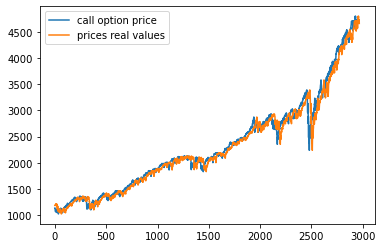

In [31]:
plt.plot(call_prices[:,2], label='call option price')
plt.plot(SPX_price.Close.values, label='prices real values')
plt.legend()

In [32]:
call_prices = np.insert( call_prices, 0, np.full( ( n, Npaths ), np.nan ), axis=0 )

for k in range(Npaths):
    col      = 'call_sim_' + str( k )
    UX1[col] = pd.Series( call_prices[:,k], index = UX1.index)

UX1['mean_call'] = ( UX1.loc[:, ['call_sim_' + str( k ) for k in range( Npaths ) ] ] ).mean( axis=1 )

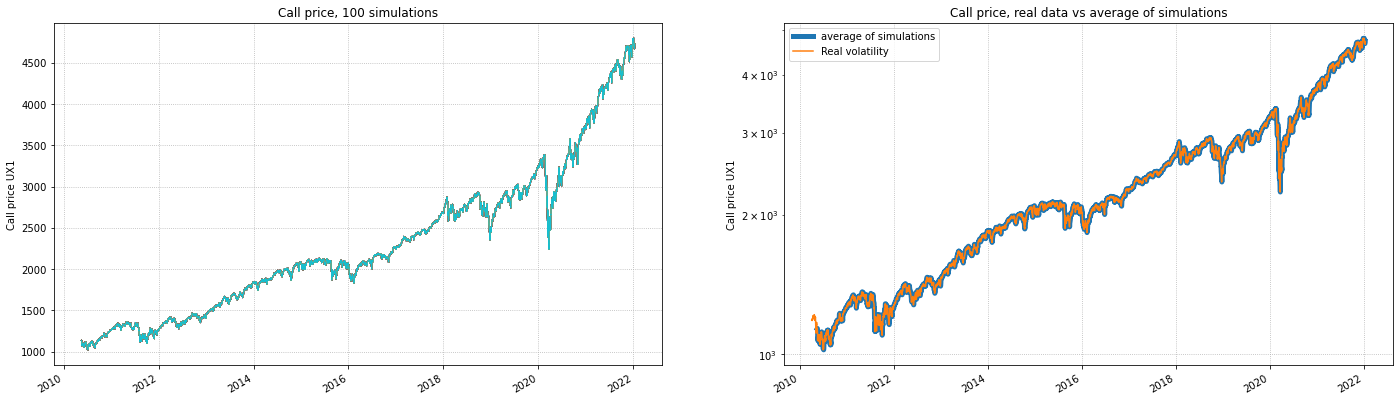

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(24,7))

for k in range(Npaths):
    col = 'call_sim_' + str(k)
    ax[0].plot(UX1.index, UX1[col], label='', lw=1)
#ax[0].plot(UX2.index, UX2.PX_LAST, lw=5, label='Real volatility')
ax[0].grid(linestyle='dotted')
#ax[0].legend(loc='best')
ax[0].set_title('Call price, ' + str(Npaths) + ' simulations')
ax[0].set_ylabel('Call price UX1')

ax[1].plot(UX1.index, UX1['mean_call'], label='average of simulations', lw=5)
ax[1].plot(UX1.index, SPX_price.Close, label='Real volatility')
ax[1].grid(linestyle='dotted')
ax[1].legend(loc='best')
ax[1].set_title('Call price, real data vs average of simulations')
ax[1].set_ylabel('Call price UX1')
ax[1].set_yscale('log')

fig.autofmt_xdate()
plt.show()

<AxesSubplot:xlabel='Date'>

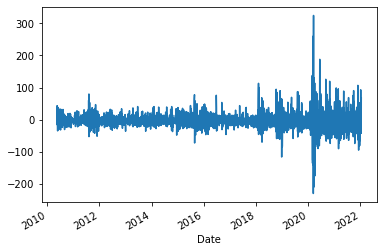

In [34]:
a = UX1['mean_call'] - SPX_price.Close
a.plot()